# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $f$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $k$. Usually, they are related following a nonlinear state-space model:
<img src=https://tandeo.files.wordpress.com/2019/02/formule_nnss_model.png width="200">
with $\eta$ and $\epsilon$ some independant white Gaussian noises respectively respresenting the model forecast error and the error of observation.

In classical data assimilation, we require multiple runs of an explicit dynamical model $f$ with possible severe limitations including the computational cost, the lack of consistency of the model with respect to the observed data as well as modeling uncertainties. Here, an alternative strategy is explored by developing a fully data-driven assimilation. No explicit knowledge of the dynamical model is required. Only a representative catalog of trajectories of the system is assumed to be available. Based on this catalog, the Analog Data Assimilation (AnDA) is introduced by combining machine learning with the analog method (or nearest neighbor search) and stochastic assimilation techniques including Ensemble Kalman Filter and Smoother (EnKF, EnKS) and Particle Filter (PF). We test the accuracy of the technic on different chaotic dynamical models, the Lorenz-63 and Lorenz-96 systems.

This Julia program is dervied from the Python library is attached to the following publication:
Lguensat, R., Tandeo, P., Ailliot, P., Pulido, M., & Fablet, R. (2017). The Analog Data Assimilation. *Monthly Weather Review*, 145(10), 4093-4107.
If you use this library, please do not forget to cite this work.

# IMPORT PACKAGES


In [1]:
using Pkg
using Plots
using DifferentialEquations
using Revise

In [2]:
Pkg.activate(@__DIR__)
Pkg.instantiate()


  Activating project at `~/JuliaProjects/AnalogDataAssimilation.jl`
Precompiling project...
  ✗ AnalogDataAssimilation
  0 dependencies successfully precompiled in 15 seconds (264 already precompiled)
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


# TEST ON LORENZ-63

To begin, as dynamical model $f$, we use the Lorenz-63 chaotic system. First, we generate simulated trajectories from this dynamical model and store them into the catalog. Then, we use this catalog to emulate the dynamical model and we apply the analog data assimilation. Finally, we compare the results of this data-driven approach to the classical data assimilation (using the true Lorenz-63 equations as dynamical model).

### GENERATE SIMULATED DATA (LORENZ-63 MODEL)

In [24]:
using AnalogDataAssimilation

σ = 10.0
ρ = 28.0
β = 8.0/3

dt_integration = 0.01
dt_states      = 1 
dt_obs         = 8 
parameters     = [σ, ρ, β]
var_obs        = [1]
nb_loop_train  = 100 
nb_loop_test   = 10
sigma2_catalog = 0.0
sigma2_obs     = 2.0

ssm = StateSpaceModel( lorenz63,
                       dt_integration, dt_states, dt_obs, 
                       parameters, var_obs,
                       nb_loop_train, nb_loop_test,
                       sigma2_catalog, sigma2_obs )

# compute x0 at time = 5  to be in the attractor space
prob  = ODEProblem(ssm.model, [8.0;0.0;30.0], (0.0,5.0), parameters)
x0    = last(solve(prob, reltol=1e-6, save_everystep=false))

xt, yo, catalog = generate_data( ssm, x0 );

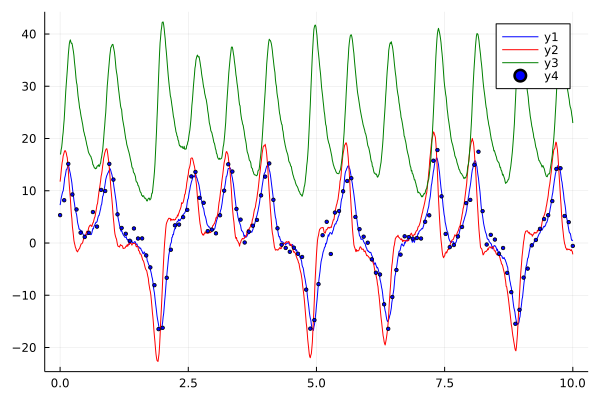

In [25]:
plot( xt.time, xt[1], lc=:blue)
plot!( xt.time, xt[2], lc=:red)
plot!( xt.time, xt[3], lc=:green)
scatter!( yo.time, yo[1]; markersize=2, markercolor=:blue)

In [26]:
regression = :local_linear
sampling = :gaussian
k, np = 50, 100

(50, 100)

### CLASSICAL DATA ASSIMILATION (dynamical model given by the equations)

In [27]:
DA = DataAssimilation( ssm, xt )
x̂_classical = forecast(DA, yo, EnKS(np))
@time RMSE( xt, x̂_classical)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.000464 seconds (10.05 k allocations: 429.156 KiB)


1.2001523734044248

### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)

In [28]:
f  = AnalogForecasting( k, xt, catalog; regression = regression, sampling   = sampling )
DA = DataAssimilation( f, xt, ssm.sigma2_obs )
x̂_analog = forecast( DA, yo, EnKS(np))
@time RMSE( xt, x̂_analog)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


  0.000614 seconds (10.05 k allocations: 429.156 KiB)


1.082455316781548

### COMPARISON BETWEEN CLASSICAL AND ANALOG DATA ASSIMILATION

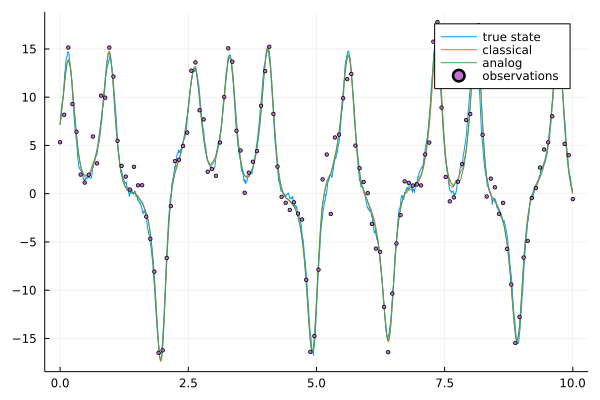

In [29]:
plot( xt.time, xt[1], label="true state")
plot!( xt.time, x̂_classical[1], label="classical")
plot!( xt.time, x̂_analog[1], label="analog")
scatter!( yo.time, yo[1]; markersize=2, label="observations")

The results show that performances of the data-driven analog data assimilation are closed to those of the model-driven data assimilation. The error can be reduced by augmenting the size of the catalog "nb_loop_train".

# Remark

Note that for all the previous experiments, we use the robust Ensemble Kalman Smoother (EnKS) with the increment or local linear regressions and the Gaussian sampling. If you want to have realistic state estimations, we preconize the use of the Particle Filter (DA.method = 'PF') with the locally constant regression (AF.regression = 'locally_constant') and the multinomial sampler (AF.sampling = 'multinomial') with a large number of particles (DA.N). For more details about the different options, see the attached publication: Lguensat, R., Tandeo, P., Ailliot, P., Pulido, M., & Fablet, R. (2017). The Analog Data Assimilation. *Monthly Weather Review*, 145(10), 4093-4107.